In [4]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
with open('../tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)

In [6]:
ball_positions = [x.get(1,[]) for x in ball_positions]
df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

# interpolate the missing values
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()#backward missing values filling

In [7]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2'])/2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

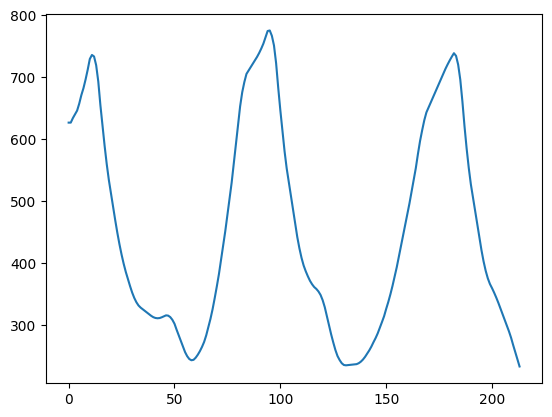

In [8]:
plt.plot(df_ball_positions['mid_y_rolling_mean'])


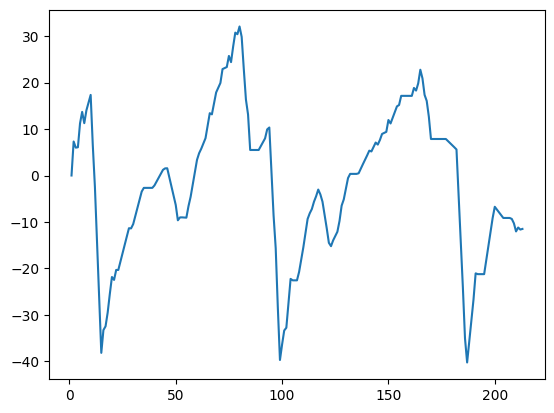

In [9]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()
plt.plot(df_ball_positions['delta_y'])


In [12]:

# Ensure 'ball_hit' column exists
df_ball_positions['ball_hit'] = 0

minimum_change_frames_for_hit = 25
hit_window = int(minimum_change_frames_for_hit * 1.2)

for i in range(1, len(df_ball_positions) - hit_window):
    negative_position_change = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i + 1] < 0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i + 1] > 0

    if negative_position_change or positive_position_change:
        change_count = 0 
        for change_frame in range(i + 1, i + hit_window + 1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[change_frame] < 0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[change_frame] > 0

            if negative_position_change and negative_position_change_following_frame:
                change_count += 1
            elif positive_position_change and positive_position_change_following_frame:
                change_count += 1

        if change_count > minimum_change_frames_for_hit - 1:
            df_ball_positions.loc[i, 'ball_hit'] = 1

frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit'] == 1].index.tolist()


In [13]:
df_ball_positions[df_ball_positions['ball_hit']==1]
#at which times ball is hitted

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,776.865967,717.329956,796.806519,738.393127,727.861542,735.918103,6.523395,1
58,925.881409,240.971036,939.039478,253.989084,247.480060,243.406101,-1.957850,1
95,624.777161,748.891968,642.157257,766.698242,757.795105,775.403400,0.871759,1
131,716.963562,229.095016,729.239868,242.786224,235.940620,235.241673,-0.557166,1
182,1294.891235,739.127197,1314.160156,760.564819,749.846008,738.733578,5.602832,1
